In [1]:
!git clone https://github.com/Upota/Transformer_Auto-Encoder.git

fatal: destination path 'Transformer_Auto-Encoder' already exists and is not an empty directory.


In [2]:
%cd Transformer_Auto-Encoder/

/content/Transformer_Auto-Encoder


In [3]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [4]:
# make deterministic
from utils import set_seed
set_seed(42)

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Denoising Signal

1. $$ sin(t) + \epsilon $$
2. $$ \sum^{n}{a sin(bt + c)} + \epsilon $$

## Data generation

### Data 1

In [6]:
# set parameters
block_size = 128

n_in = 1
n_sample = 51200
# n_sample = 16

In [7]:
# generate sequential sine signal
x_interval = 0.09
sin_x = np.linspace(0, x_interval * n_sample, num=n_sample)
pure_sin = np.sin(sin_x)
noisy_sin = pure_sin + 0.1 * np.random.randn(pure_sin.shape[0])

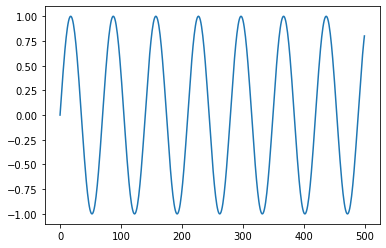

In [8]:
pure = pure_sin[0:500]
plt.plot(range(len(pure)), pure)

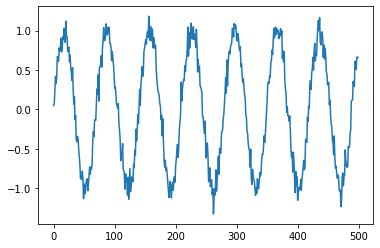

In [9]:
noisy = noisy_sin[0:500]
plt.plot(range(len(noisy)), noisy)

In [10]:
class SinDataset(Dataset): # build custom dataset
    
    def __init__(self, x, y, block_size):
        self.block_size = block_size
        self.x = x # noisy_sin
        self.y = y # pure_sin
    
    def __getitem__(self, idx):
        # grab a chunk of (block_size) elements from the data
        noisy_chunk = self.x[idx:idx + self.block_size]
        pure_chunk = self.y[idx:idx + self.block_size]
    
        x = torch.tensor(noisy_chunk, dtype=torch.float)
        y = torch.tensor(pure_chunk, dtype=torch.float)
        return x, y
    
    def __len__(self):
        return len(self.x) - self.block_size

In [11]:
train_dataset1 = SinDataset(noisy_sin, pure_sin, block_size)

### Data 2

In [12]:
# generate sequential complex sine signal
x_interval = 0.2
sin_x = np.linspace(0, x_interval * n_sample, num=n_sample)
sin_1 = np.sin(sin_x) # sin(t)
sin_2 = 1.5 * np.sin(0.5 * sin_x + 0.3 * np.pi) # 1.5sin(t + 0.3pi)
pure_sin = sin_1 + sin_2
noisy_sin = pure_sin + 0.2 * np.random.randn(pure_sin.shape[0])

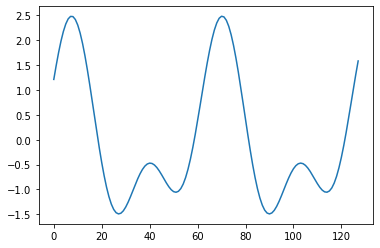

In [13]:
pure = pure_sin[0:128]
plt.plot(range(len(pure)), pure)

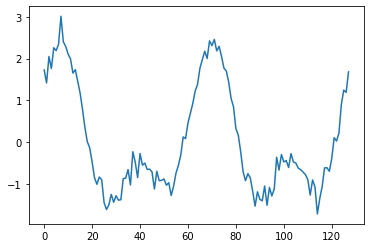

In [14]:
noisy = noisy_sin[0:128]
plt.plot(range(len(noisy)), noisy)

In [15]:
train_dataset2 = SinDataset(noisy_sin, pure_sin, block_size)

## Model

In [16]:
from model import TAE, TAEConfig
mconf = TAEConfig(n_in, block_size,
                 n_layer=2, n_head=4, n_embd=128)
model = TAE(mconf)

07/28/2021 18:53:25 - INFO - model - number of parameters: 9.265920e+05


In [17]:
import gc
gc.collect()

53

In [18]:
from pathlib import Path

PATH = Path("model")
FILENAME = "data2" + ".ckpt"
ckpt_path = PATH / FILENAME
# ckpt_path = None
if ckpt_path is not None and ckpt_path.exists():
    print("load")
    model.load_state_dict(torch.load(ckpt_path))

load


## Training

In [19]:
from trainer import Trainer, TrainerConfig
tconf = TrainerConfig(max_epochs=51, batch_size=256, learning_rate=6e-4,
                     lr_decay = True, ckpt_path=ckpt_path,
                     num_workers=4)
trainer = Trainer(model, train_dataset2, None, tconf)
trainer.train()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch 1 iter 199: train loss 0.02533. lr 6.000000e-04: 100%|██████████| 200/200 [00:37<00:00,  5.33it/s]
07/28/2021 18:54:06 - INFO - trainer - saving model/data2.ckpt
epoch 2 iter 199: train loss 0.02233. lr 5.994310e-04: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
07/28/2021 18:54:43 - INFO - trainer - saving model/data2.ckpt
epoch 3 iter 199: train loss 0.02038. lr 5.977262e-04: 100%|██████████| 200/200 [00:37<00:00,  5.36it/s]
07/28/2021 18:55:21 - INFO - trainer - saving model/data2.ckpt
epoch 4 iter 199: train loss 0.01908. lr

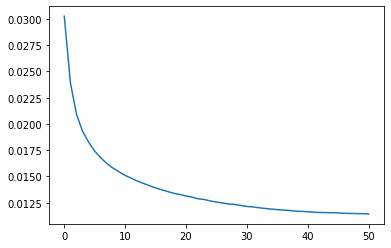

In [20]:
plt.plot(range(len(trainer.losses)), trainer.losses)

## Testing

In [21]:
from utils import sample
start_idx = 300
x = torch.tensor(noisy_sin[start_idx : start_idx + block_size], dtype=torch.float).to(trainer.device).view(1, block_size)
y = sample(model, x)[0]
y = y.cpu().numpy()

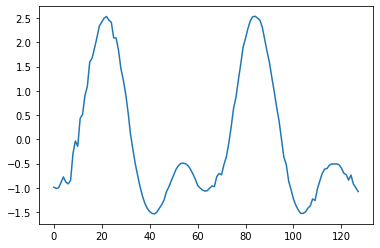

In [22]:
plt.plot(range(len(y)), y)

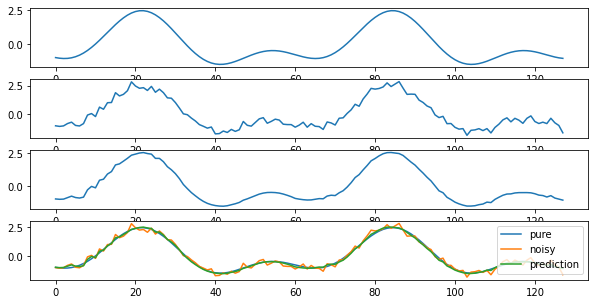

In [23]:
pure = pure_sin[start_idx : start_idx + block_size]
noisy = noisy_sin[start_idx : start_idx + block_size]

plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(range(block_size), pure, label='pure')

plt.subplot(412)
plt.plot(range(block_size), noisy, label='noisy')

plt.subplot(413)
plt.plot(range(len(y)), y, label='prediction')

plt.subplot(414)
plt.plot(range(block_size), pure, label='pure')
plt.plot(range(block_size), noisy, label='noisy')
plt.plot(range(len(y)), y, label='prediction')
plt.legend()
plt.show()

In [24]:
print(np.sum((pure - noisy) ** 2))
print(np.sum((pure - y.reshape(-1)) ** 2))

6.114268394870074
0.9449027806854069
